In [6]:
!pip install --upgrade --force-reinstall transformers


  Using cached transformers-4.53.2-py3-none-any.whl.metadata (40 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.3/515.3 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 104.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.0/763.0 kB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.7/792.7 kB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 99.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5

In [1]:
from google.colab import files
uploaded = files.upload()


Saving both_test.csv to both_test.csv


In [19]:
from datasets import Dataset
from transformers import DistilBertForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import pandas as pd
import shap
from transformers import pipeline
import numpy as np


def load_data_multiclass(path):
    df = pd.read_csv(path, names=["text", "diagnosis", "label_id"])
    label2id = {label: i for i, label in enumerate(df["diagnosis"].unique())}
    df["label"] = df["diagnosis"].map(label2id)
    return df, label2id




def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}


'''
def explain_with_shap(trained_model, tokenizer, texts, max_samples=20):
    from transformers import pipeline
    import shap
    import matplotlib.pyplot as plt

    sample_texts = [t[:300] for t in texts[:max_samples].tolist()]
    pipe = pipeline("text-classification", model=trained_model, tokenizer=tokenizer, return_all_scores=True)

    print(f"\n🧠 Running SHAP on {len(sample_texts)} samples...")

    explainer = shap.Explainer(pipe, algorithm="partition", output_names=["non-disorder", "disorder"])
    shap_values = explainer(sample_texts)

    shap.summary_plot(shap_values[1], sample_texts, max_display=20, show=False)

    plt.savefig("shap_summary_top20.png")
    plt.savefig("shap_summary.png")

    return shap_values
'''
def train_binary_classifier():
    print(f"\n🔍 Training Mutliclass Classifier")
    df, label2id = load_data_multiclass("both_train.csv")

    # Optional: downsample to balance
    pos = df[df.label == 1]
    neg = df[df.label == 0].sample(len(pos), random_state=42, replace=True)
    df = pd.concat([pos, neg]).sample(frac=1, random_state=42)

    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    train_dataset = Dataset.from_pandas(train_df)
    test_dataset = Dataset.from_pandas(test_df)

    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    def tokenize(example): return tokenizer(example['text'], truncation=True, padding="max_length")

    train_dataset = train_dataset.map(tokenize, batched=True)
    test_dataset = test_dataset.map(tokenize, batched=True)
    num_labels = len(label2id)

    model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels)

    training_args = TrainingArguments(
        output_dir=f"./results_multiclass",
        num_train_epochs=3,
        per_device_train_batch_size=16,
        weight_decay=0.01,
        logging_dir='./logs',
        eval_strategy="epoch",
        save_strategy="no",
        report_to="tensorboard"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    eval_result = trainer.evaluate()
    # Get raw predictions for error analysis
    predictions_output = trainer.predict(test_dataset)
    preds = predictions_output.predictions.argmax(axis=-1)
    labels = predictions_output.label_ids

    # Add predictions to test_df for error analysis
    test_df = test_df.reset_index(drop=True).copy()
    test_df['prediction'] = preds
    test_df['label'] = labels

    return eval_result, test_df, label2id




In [20]:
results, df_with_preds, label2id = train_binary_classifier()
print(results)



🔍 Training Mutliclass Classifier


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/3171 [00:00<?, ? examples/s]

Map:   0%|          | 0/793 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-19-820713971.py:83: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.000504,1.000000,1.000000,1.000000,1.000000
2,No log,0.000183,1.000000,1.000000,1.000000,1.000000
3,0.030200,0.000134,1.000000,1.000000,1.000000,1.000000


{'eval_loss': 0.0001342010946245864, 'eval_accuracy': 1.0, 'eval_f1': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_runtime': 11.1087, 'eval_samples_per_second': 71.386, 'eval_steps_per_second': 9.002, 'epoch': 3.0}



🔍 Training for: ptsd


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/396 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2-1778660004.py:79: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.438118,0.770000,0.752688,0.921053,0.636364
2,No log,0.398995,0.820000,0.850000,0.784615,0.927273
3,No log,0.319643,0.850000,0.862385,0.870370,0.854545


Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(



🧠 Running SHAP on 20 samples...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
PartitionExplainer explainer:  35%|███▌      | 7/20 [00:22<00:33,  2.55s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 21it [01:06,  3.50s/it]
/tmp/ipython-input-2-1778660004.py:40: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[1], sample_texts, max_display=20, show=False)



🔍 Training for: bipolar


Map:   0%|          | 0/396 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2-1778660004.py:79: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.555870,0.740000,0.771930,0.745763,0.800000
2,No log,0.512680,0.740000,0.775862,0.737705,0.818182
3,No log,0.531518,0.770000,0.776699,0.833333,0.727273


Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(



🧠 Running SHAP on 20 samples...


PartitionExplainer explainer: 21it [00:55,  3.28s/it]
/tmp/ipython-input-2-1778660004.py:40: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[1], sample_texts, max_display=20, show=False)


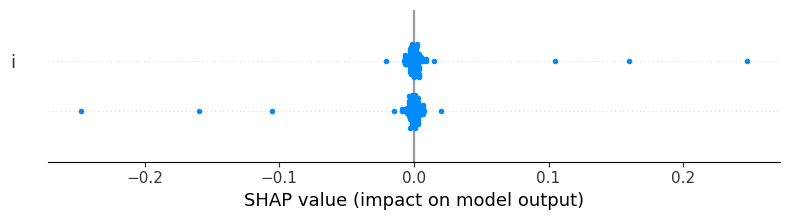

In [2]:
from datasets import Dataset
from transformers import DistilBertForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import pandas as pd
import shap
from transformers import pipeline
import numpy as np


def load_filtered_data(path, target_disorder):
    df = pd.read_csv("both_train.csv", names=["text", "diagnosis", "label_id"])
    #df = df[df['class_name'].isin(['ptsd', 'bipolar'])].copy()
    df['label'] = df['diagnosis'].apply(lambda x: 1 if x.strip().lower() == target_disorder.lower() else 0)
    #df['text'] = df['title'].fillna('') + ' ' + df['post'].fillna('')
    return df



def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

def explain_with_shap(trained_model, tokenizer, texts, max_samples=20):
    from transformers import pipeline
    import shap
    import matplotlib.pyplot as plt

    sample_texts = [t[:300] for t in texts[:max_samples].tolist()]
    pipe = pipeline("text-classification", model=trained_model, tokenizer=tokenizer, return_all_scores=True)

    print(f"\n🧠 Running SHAP on {len(sample_texts)} samples...")

    explainer = shap.Explainer(pipe, algorithm="partition", output_names=["non-disorder", "disorder"])
    shap_values = explainer(sample_texts)

    shap.summary_plot(shap_values[1], sample_texts, max_display=20, show=False)

    plt.savefig("shap_summary_top20.png")
    plt.savefig("shap_summary.png")

    return shap_values

def train_binary_classifier(disorder):
    print(f"\n🔍 Training for: {disorder}")
    df = load_filtered_data("/both_train.csv", disorder)

    # Optional: downsample to balance
    pos = df[df.label == 1]
    neg = df[df.label == 0].sample(len(pos), random_state=42)
    df = pd.concat([pos, neg]).sample(frac=1, random_state=42)

    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    train_dataset = Dataset.from_pandas(train_df)
    test_dataset = Dataset.from_pandas(test_df)

    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    def tokenize(example): return tokenizer(example['text'], truncation=True, padding="max_length")

    train_dataset = train_dataset.map(tokenize, batched=True)
    test_dataset = test_dataset.map(tokenize, batched=True)

    model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
    training_args = TrainingArguments(
        output_dir=f"./results_{disorder}",
        num_train_epochs=3,
        per_device_train_batch_size=16,
        weight_decay=0.01,
        logging_dir='./logs',
        eval_strategy="epoch",
        save_strategy="no",
        report_to="tensorboard"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    eval_result = trainer.evaluate()
    # Get raw predictions for error analysis
    predictions_output = trainer.predict(test_dataset)
    preds = predictions_output.predictions.argmax(axis=-1)
    labels = predictions_output.label_ids

    # Add predictions to test_df for error analysis
    test_df = test_df.reset_index(drop=True).copy()
    test_df['prediction'] = preds
    test_df['label'] = labels

    explain_with_shap(model, tokenizer, test_df["text"])

    return eval_result, test_df

    print(f"📊 {disorder} Evaluation:", eval_result)
    return eval_result

ptsd_results, ptsd_df = train_binary_classifier("ptsd")
bipolar_results, bipolar_df = train_binary_classifier("bipolar")